In [66]:
# %reload_ext autoreload
# %autoreload 1   
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# import pytorch_models
import imp
# imp.reload(pytorch_models)
# from pytorch_models import CNN_net

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.01

In [67]:
TRAIN_DATA_PATH = "./cnn_data/train"
TEST_DATA_PATH = "./cnn_data/test"
TRANSFORM_IMG = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=test_loader

classes=list(train_data.class_to_idx.keys()) #get list of classes
print(classes,len(classes))

['clap', 'guitar', 'hat', 'kick', 'piano', 'snare', 'stacks'] 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


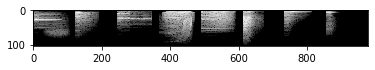

GroundTruth:  stacks        snare        piano        stacks        stacks         clap         kick        snare


In [68]:
dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))


In [69]:
#io calculator
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    print(output)
    return(output)
#get all targets


In [70]:
# let's get the weight of the samples incase we want to make a weighted
# sampler to deal with data imbalance
# # expensive to compute so commented
targets=[]
for batch_idx, (d, l) in enumerate(train_loader):
    targets.extend(list(l.numpy()))
# Compute samples weight (each sample should get its own weight)
target=torch.tensor(targets)
class_sample_count = torch.tensor(
    [(target == t).sum() for t in torch.unique(target, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in target])
print("here are the weights to account for class sizes")
print(dict(zip(classes,list(weight.numpy()*1000))))

here are the weights to account for class sizes
{'clap': 2.7027028, 'guitar': 2.6385226, 'hat': 0.6578948, 'kick': 0.9910803, 'piano': 3.058104, 'snare': 0.698812, 'stacks': 0.2247191}


In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(25 * 30 * 64, 1000)
        self.fc2 = nn.Linear(1000, 7)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [72]:
def trainCNN(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    n_batches = len(train_loader)
    loss = torch.nn.CrossEntropyLoss(weight=weight.to(device))    
    optimizer = optim.Adadelta(net.parameters(),learning_rate)
    
    #get time
    training_start_time = time.time()    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels =  data[0].to(device), data[1].to(device)
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 20th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()

        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels =  inputs.to(device), labels.to(device)
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./models/cnn/model-%s-%s.states"%(BATCH_SIZE,epoch))
            
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [ ]:
CNN = ConvNet()
CNN.to(device)
trainCNN(CNN, batch_size=BATCH_SIZE,n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 8
epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.89 took: 2.51s
Epoch 1, 20% 	 train_loss: 1.73 took: 2.34s
Epoch 1, 30% 	 train_loss: 1.61 took: 2.34s
Epoch 1, 40% 	 train_loss: 1.50 took: 2.34s
Epoch 1, 50% 	 train_loss: 1.46 took: 2.34s
Epoch 1, 60% 	 train_loss: 1.39 took: 2.34s
Epoch 1, 70% 	 train_loss: 1.29 took: 2.34s
Epoch 1, 80% 	 train_loss: 1.19 took: 2.34s
Epoch 1, 90% 	 train_loss: 1.20 took: 2.35s
Validation loss = 1.11
Epoch 2, 10% 	 train_loss: 1.05 took: 2.52s
Epoch 2, 20% 	 train_loss: 1.02 took: 2.39s
Epoch 2, 30% 	 train_loss: 0.97 took: 2.40s
Epoch 2, 40% 	 train_loss: 1.02 took: 2.38s
Epoch 2, 50% 	 train_loss: 0.99 took: 2.38s
Epoch 2, 60% 	 train_loss: 0.95 took: 2.39s
Epoch 2, 70% 	 train_loss: 0.93 took: 2.38s
Epoch 2, 80% 	 train_loss: 0.89 took: 2.39s
Epoch 2, 90% 	 train_loss: 0.91 took: 2.38s
Validation loss = 0.85
Epoch 3, 10% 	 train_loss: 0.86 took: 2.53s
Epoch 3, 20% 	 train_loss: 0.82 took: 2.40s


In [52]:
s=torch.load("models/cnn/model-4-9.states")
cnn = ConvNet()
cnn.load_state_dict(s["model_state_dict"])
cnn.to(device)

# cnn.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=48000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=7, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


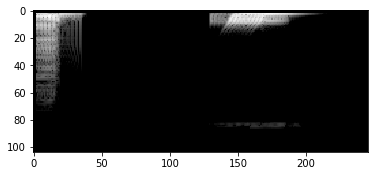

GroundTruth:   kick        stacks
Predicted:     kick        stacks


In [53]:
dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))
dimg=images.to(device)
outputs=CNN(dimg)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', '        '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))

In [55]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 86 %


In [56]:
class_correct = list(0. for i in range(19))
class_total = list(0. for i in range(19))

with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except:
                continue

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  clap :  7 %
Accuracy of guitar : 62 %
Accuracy of   hat : 89 %
Accuracy of  kick : 87 %
Accuracy of piano : 63 %
Accuracy of snare : 79 %
Accuracy of stacks : 98 %


(7.0, 0.0)

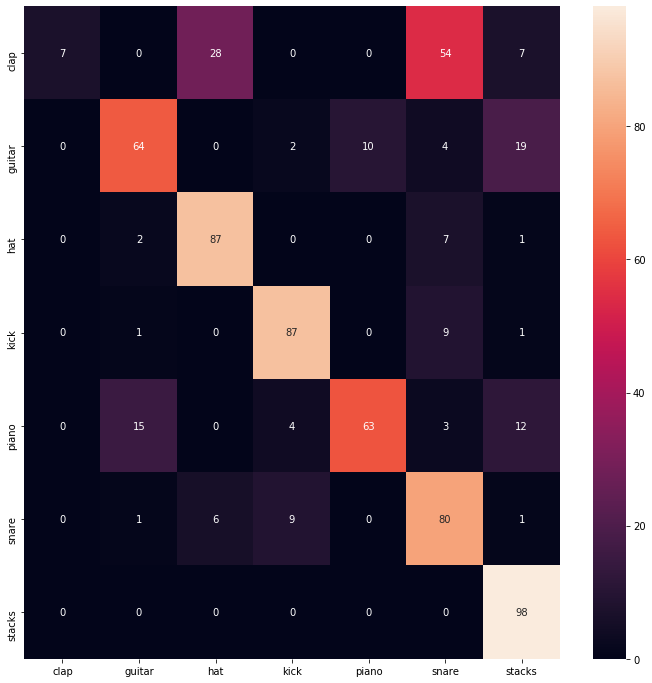

In [57]:
## making a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
# plt.show() # ta-da!
predictions=[]
l=[]
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())
cm=confusion_matrix(l,predictions)

# normalize confusion matrix per class
for i,c in enumerate(cm):
    cm[i]=c/sum(c)*100


df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,12))
sn.heatmap(df_cm, annot=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values